# Canny Edge Detector

This Jupyter notebook is provided to complement the paper illustrating edge detection with Canny's algorithm as an example of image segmentation.


Two main parts will be highlighted:
- Implementation
- Comparative analysis

## Implementation

The *Canny edge detector* is an edge detection operator developed by John F. Canny in 1986 that uses a multi-stage algorithm to detect a wide range of edges in images.

It can be summarized in this 5-step process:
```
1. Noise reduction
2. Gradient computation
3. Non-maximum suppression
4. Double thresholding
5. Hysteresis edge tracking
```

**Please note:** The algorithm requires grayscale pictures to function properly.

Images showing the partial results of the process will be provided after each of the 5 steps to help the viewer have an outright visual understanding on how each step contributes to the end result. Have a look at the *images* folder for a quick overview.

In [1]:
# Import libraries
import cv2 as cv

import numpy as np

from skimage import color
from skimage import io
from skimage import img_as_float
from skimage import exposure
from skimage import filters

from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

In [2]:
def plot_image_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram
    and its cumulative distribution function."""
    float_image = img_as_float(image)
    
    axis_image, axis_hist = axes
    axis_cdf = axis_hist.twinx()

    # Display image
    axis_image.imshow(float_image, cmap=cm.gist_gray)

    # Display histogram
    axis_hist.hist(float_image.ravel(), bins=bins,
                    histtype='step', color='black')
    axis_hist.ticklabel_format(axis='y',
                    style='scientific', scilimits=(0, 0))
    
    axis_hist.set_xlabel('Pixel intensity')
    axis_hist.set_xlim(0, 1)
    axis_hist.set_yticks([])

    # Display cumulative distribution
    image_cdf, bins = exposure.cumulative_distribution(
            float_image, bins)
    
    axis_cdf.plot(bins, image_cdf, 'r')
    axis_cdf.set_yticks([])

    return axis_image, axis_hist, axis_cdf

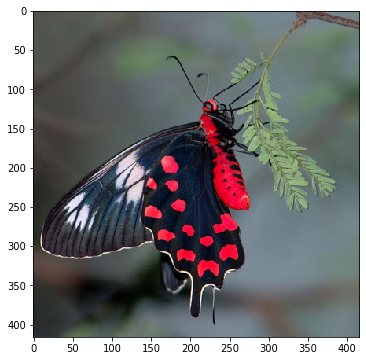

In [3]:
rgb_image = io.imread('./images/butterfly.bmp')

plt.figure(figsize=(16, 6))
plt.imshow(rgb_image)

### Convert RGB to grayscale

$Y = 0.2125*R + 0.7154*G + 0.0721*B$

(<matplotlib.axes._subplots.AxesSubplot at 0x166069ddf48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x166069dde88>)

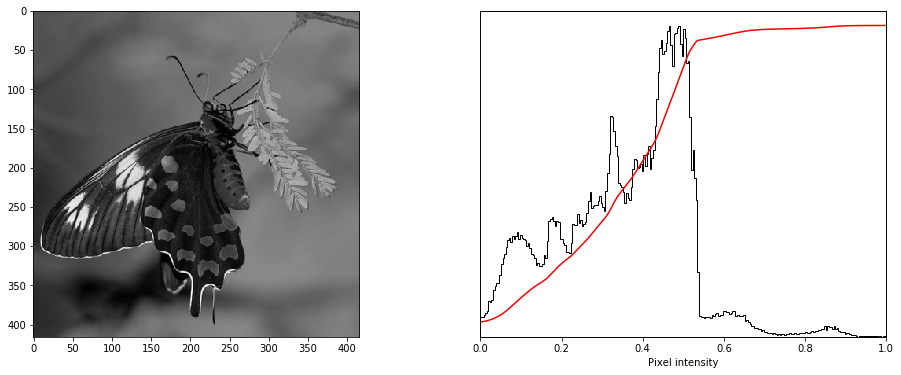

In [4]:
gray_image = color.rgb2gray(rgb_image)

_, axes = plt.subplots(1, 2, figsize=(16,6))
plot_image_and_hist(gray_image, axes)

### Noise reduction

Since the mathematics involved under the hood builds upon derivatives (i.e., *Gradient calculation*), edge detection results are highly sensitive to the amount of noise in the image. One way to get rid of it, is by applying Gaussian blur to smooth it. To do so, the image is convolved with a Gaussian kernel ($3 \times 3$, $5 \times 5$, $7 \times 7$, etc...) whose size depends on the expected blurring effect. The smallest the kernel, the less visible the blur.

The equation for a Gaussian filter kernel of size $(2k+1) \times (2k+1)$ is given by:

$
    H_{i,j} = \frac{1}{2\pi\sigma} \exp \left( - \frac{\left( i - \left( k + 1 \right) \right) ^ 2 + \left( j - \left( k + 1 \right) \right) ^ 2}{2\sigma^2} \right) \quad \textrm{with} \quad 1 \leq i,j \leq (2k + 1)
$

In [5]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    X, Y = np.mgrid[-size:size+1, -size:size+1]
    
    normal_factor = 1 / (2.0 * np.pi * sigma**2)
    
    return np.exp(-((X**2 + Y**2) / (2.0*sigma**2))) \
                    * normal_factor

In our example, I will use a $3 \times 3$ and a $5 \times 5$ Gaussian kernels:

In [6]:
kernel_3_3 = gaussian_kernel(3)
kernel_5_5 = gaussian_kernel(5, sigma=3)

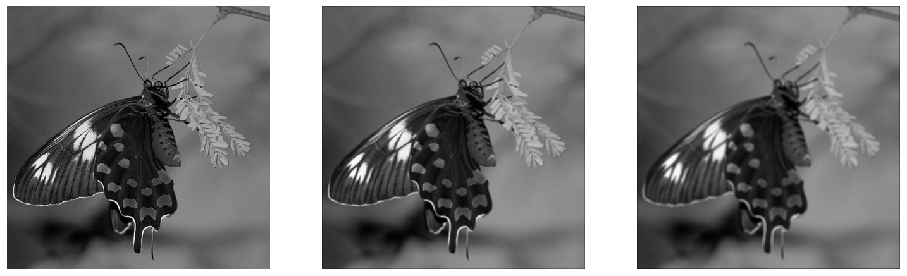

In [10]:
filter_image_3_3 = signal.convolve2d(gray_image,
            kernel_3_3, mode='same')

filter_image_5_5 = signal.convolve2d(gray_image,
            kernel_5_5, mode='same')

plt.figure(figsize=(16,6))

plt.subplot(131)
plt.imshow(gray_image, cmap=cm.gist_gray)
plt.title('Original image')

plt.subplot(132)
plt.imshow(filter_image_3_3, cmap=cm.gist_gray)
plt.title(r'Gaussian $3 \times 3$ filtered image')

plt.subplot(133)
plt.imshow(filter_image_5_5, cmap=cm.gist_gray)
plt.title(r'Gaussian $5 \times 5$ filtered image')

I computed the residual sum of squares (*RSS*) in order to verify the different smoothing effect the Gaussian kernels had. As I anticipated before, the kernel size strongly affects the blurring effect and thus the $5 \times 5$ kernel achieves a higher score, as expected:

In [9]:
rss = np.sum(np.square(filter_image_5_5
            - filter_image_3_3))

np.allclose(rss, 1e-05, 1e-10)

False

Literature suggests to use a $5 \times 5$ Gaussian kernel with $\sigma=1.4$:

<img src=".\images\Gauss_5_5_mask.jpg" align="center"/>

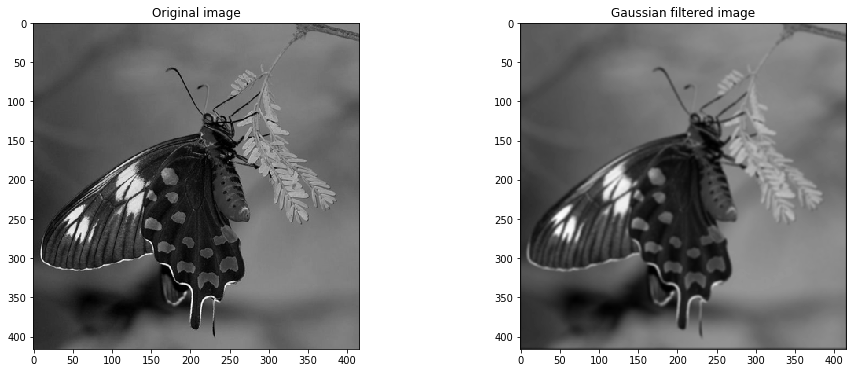

In [10]:
smooth_kernel = gaussian_kernel(5, sigma=1.4)
smooth_image  = signal.convolve2d(gray_image,
            smooth_kernel, mode='same')

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(gray_image, cmap=cm.gist_gray)
plt.title('Original image')

plt.subplot(122)
plt.imshow(smooth_image, cmap=cm.gist_gray)
plt.title(r'Gaussian filtered image');

### Gradient computation

Edges are defined as an abrupt change in pixels’ intensity. Filters that emulate computing the gradient are used to highlight the intensity change along an edge in both directions: horizontal (*X*) and vertical (*Y*). It can be implemented by convolving the smoothed image $I$ with specific operator kernels $K_x$ and $K_y$. This results in the image's partial derivatives $I_x$ and $I_y$, respectively. Literature suggests the use of *Sobel* and *Prewitt* operators, whose kernels are depicted below.

<br>

**Sobel** operator:
$
\quad \;\; K_x = \begin{pmatrix}-1 & 0 & 1\\-2 & 0 & 2\\-1 & 0 & 1\end{pmatrix},
\quad K_y = \begin{pmatrix}1 & 2 & 1\\0 & 0 & 0\\-1 & -2 & -1\end{pmatrix}
$

<br>

**Prewitt** operator:
$
\quad K_x = \begin{pmatrix}-1 & 0 & 1\\-1 & 0 & 1\\-1 & 0 & 1\end{pmatrix},
\quad K_y = \begin{pmatrix}1 & 1 & 1\\0 & 0 & 0\\-1 & -1 & -1\end{pmatrix}
$

<br>

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated as follows:
$$
    |G| = \sqrt{I_x^2 + I_y^2}\\
    \theta(x, y) = \arctan \left( \frac{I_y}{I_x} \right)
$$

In [11]:
def gradient_filters(image, operator='sobel', plot=False):
    if operator == 'sobel':
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    elif operator == 'prewitt':
        Kx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], np.float32)
    else:
        raise ValueError('Kernel operator not supported yet')
        
    Ix = signal.convolve2d(image, Kx, mode='same')
    Iy = signal.convolve2d(image, Ky, mode='same')
    
    # Compute the magnitude G and
    # normalize to the bound 255
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    
    # Compute the slope theta
    theta = np.arctan2(Iy, Ix)
    
    if plot:
        import matplotlib.pyplot as plt
        
        fig = plt.figure(figsize=(16,6))
        fig.suptitle('%s operator' % operator.capitalize())

        plt.subplot(131)
        plt.imshow(Ix, cmap=cm.gist_gray)
        plt.title(r'$I_x$')

        plt.subplot(132)
        plt.imshow(Iy, cmap=cm.gist_gray)
        plt.title(r'$I_y$')

        plt.subplot(133)
        plt.imshow(G, cmap=cm.gist_gray)
        plt.title(r'$G = \sqrt{I_x^2+I_y^2}$')

        plt.tight_layout()
    
    return G, theta

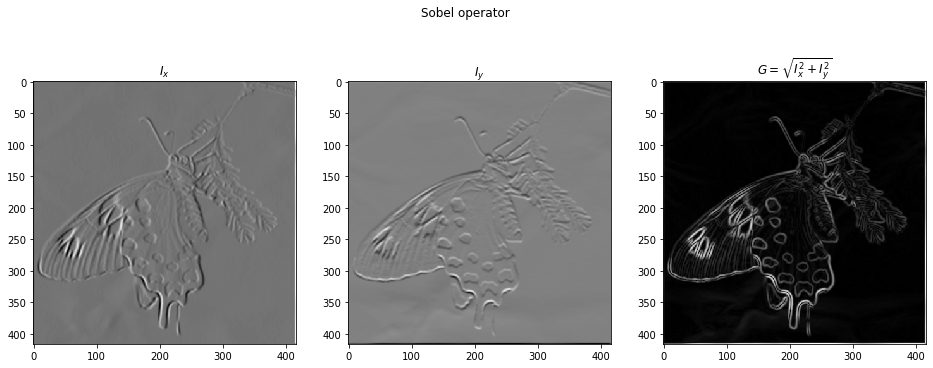

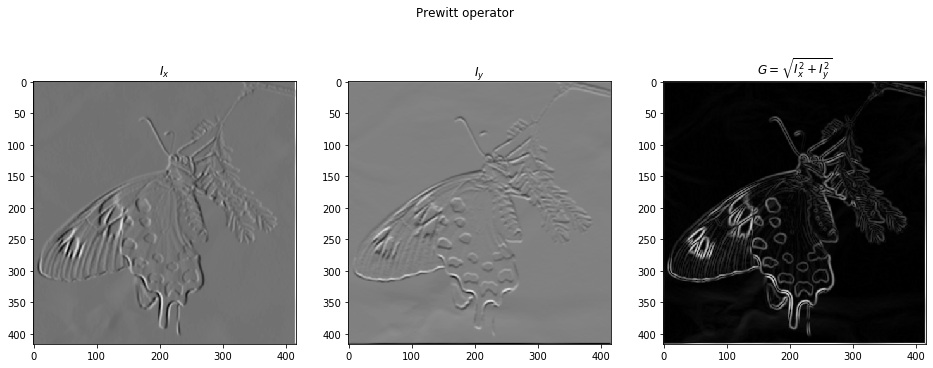

In [12]:
gradient_filters(smooth_image, operator='sobel', plot=True)
G, theta = gradient_filters(smooth_image, operator='prewitt', plot=True)

This results in an edge map which is almost the expected one, but some of the edges are thick and others are thin. *Non-maximum suppression* step will help mitigate this issue and approximate to the ideal 1-pixel wide edges. Moreover, the gradient intensity level $G$ is between 0 and 255, which is not uniform, while the edges in the end result should all have the same intensity (i.e., *255*). **Sobel** will be the operator of choice from now on.

### Non-maximum suppresion

The **NMS** algorithm is simple. It has to visit all the points on the gradient intensity matrix $G$ and find the pixels with the maximum value along a number of quantized edge directions to choose from, here equal to $8$: $\begin{bmatrix}0 & \pm\frac{\pi}{4} & \pm\frac{\pi}{2} & \pm\frac{3\pi}{4} & \pi\end{bmatrix}$. Each pixel has 2 main criteria:
- Edge direction $\theta$ in radians, $\perp$ to the edge.
- Pixel intensity $G$ (0–255).

<br>

Based on these inputs **NMS** results in a *4-step process*:

1. Create a zeros matrix $R$ of the same size of the original gradient intensity matrix $G$;

2. Identify the quantized edge direction based on the angle value from the angle matrix $\theta$;

3. Check if the neighbor pixels along the quantized edge direction have a higher intensity than the pixel that is currently processed. If they have, set its intensity level to $0$, otherwise just copy its intensity level to the $(i, j)$ location in $R$;

4. Return the matrix $R$ after **NMS** has visited all the pixels.


In [13]:
def non_max_suppression(G, theta):
    n, D = G.shape
    
    # Init zeros matrix R
    R = np.zeros((n, D), dtype=np.int32)
    
    # Convert radians to degrees
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(n):
        for j in range(D):
            try:
                # Init neighbors' value to max 255
                q = 255
                r = 255
                
                # Quantize the edge direction, then
                # find the correct neighbors r and
                # q depending on the angle value.
                
                # 0°
                if (0 <= angle[i, j] < 22.5) \
                        or (157.5 <= angle[i, j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                # 45°
                elif (22.5 <= angle[i, j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                # 90°
                elif (67.5 <= angle[i, j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                # 135°
                elif (112.5 <= angle[i, j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]

                # If the pixel currently visited has
                # the highest value along the edge direction
                # copy its value to R...
                if (G[i, j] >= q) and (G[i, j] >= r):
                    R[i, j] = G[i, j]
                # ...otherwise set it to 0
                else:
                    R[i, j] = 0

            except IndexError as e:
                pass
    
    return R

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

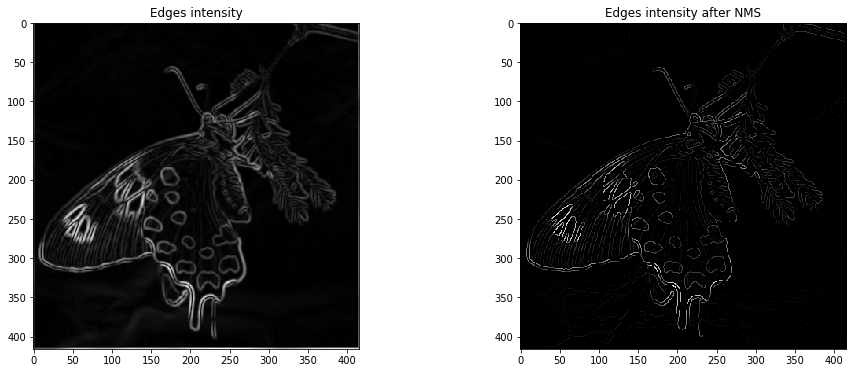

In [14]:
nms_G = non_max_suppression(G, theta)

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(G, cmap=cm.gist_gray)
plt.title('Edges intensity')

plt.subplot(122)
plt.imshow(nms_G, cmap=cm.gist_gray)
plt.title('Edges intensity after NMS')

plt.tight_layout

Non-maximum suppression procedure is an approximation by itself, which depends on the finite number of quantized directions chosen. The more the directions, the finer the approximation, as I intended before. Novel approaches based on linear interpolation among neighbor pixels have been proposed in the literature, but none will be presented in here due to time constraints, even though they have showed an higher sub-pixel accuracy.

### Double thresholding

As I said before, the gradient intensity level in $nms\_G$ is not uniform at this stage. Hence, this procedure aims at evening the pixels out in 3 discernable classes:
- *Strong pixels* - Those that have an intensity so high that we are sure they contribute to the final edges.
- *Weak pixels* &nbsp;- Those that have an intensity value that is not high enough to be considered as strong ones, but yet not small enough to be classified straight away as non-relevant towards the edge detection.
- Other pixels are considered as non-relevant for the edge.

<br>

Double thresholding's intent is now evident:
- Pixels whose intensity is higher than the high threshold are marked as strong;
- Pixels whose intensity is below the low threshold are marked as non-relevant;
- Pixels whose intensity falls in between the thresholds are flagged as weak and the subsequent Hysteresis mechanism will help separate the ones that could be considered as strong from the ones that are actually non-relevant.

<br>

Literature suggests to leave a $2$-$3$ to $1$ ration between the two thresholds. Which one to choose, though, is the real question and one which can strongly influence the goodness of Canny edge detector in both ways. I decided to follow one of the most prominent approaches, the ***Otsu's method*** at [`skimage.filters.threshold_otsu`](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_otsu). The principle behind it is actually rather simple. It looks at this as a binary classification problem between strong and non-relevant pixels, and aims at finding the threshold $t$ which minimizes the [*weighted intra-class variance*](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#how-otsu-s-binarization-works), given by the relation:
$$
    \sigma^2_w(t) := q_1(t) \sigma_1^2(t) + q_2(t) \sigma_2^2(t)
$$

In [15]:
def threshold_basic(image, low_t_ratio=0.175, high_t_ratio=0.1):
    """Basic double thresholding"""
    high_threshold = image.max() * high_t_ratio
    low_threshold  = high_threshold * low_t_ratio
    
    return high_threshold, low_threshold

In [16]:
def threshold_otsu(image):
    """Otsu's method double thresholding"""
    high_threshold = filters.threshold_otsu(image)
    low_threshold  = high_threshold * 0.125
    
    return high_threshold, low_threshold

In [17]:
def double_thresholding(image, method='otsu', low_t_ratio=0.175, high_t_ratio=0.1,
                   weak_px_val=np.int32(25), strong_px_val=np.int32(255)):
    if method == 'otsu':
        high_threshold, low_threshold = threshold_otsu(image)
    elif method == 'basic':
        high_threshold, low_threshold = threshold_basic(image,
                            low_t_ratio, high_t_ratio)
    else:
        raise ValueError('Double thresholding method not supported yet')
                
    n, D = image.shape
    thresh_G = np.zeros((n,D), dtype=np.int32)
    
    strong_px = np.where(image >= high_threshold)
    non_relev_px = np.where(image < low_threshold)
    
    weak_px = np.where((image < high_threshold)
            & (image >= low_threshold))
    
    thresh_G[strong_px] = strong_px_val
    thresh_G[weak_px] = weak_px_val
    thresh_G[non_relev_px] = 0
        
    return thresh_G

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

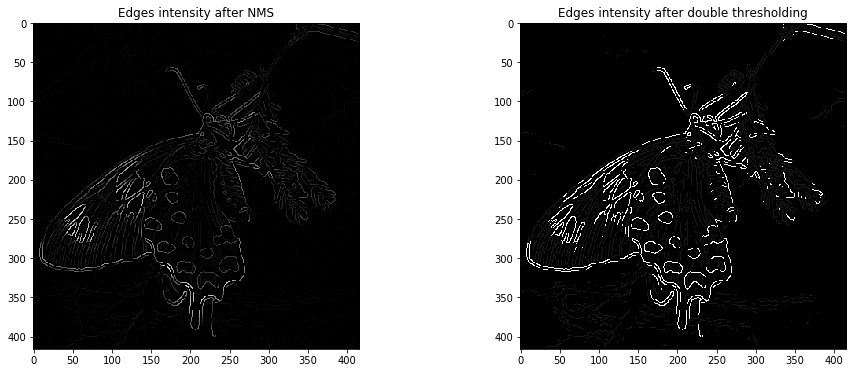

In [78]:
thresh_G = double_thresholding(nms_G, method='otsu')

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(nms_G, cmap=cm.gist_gray)
plt.title('Edges intensity after NMS')

plt.subplot(122)
plt.imshow(thresh_G, cmap=cm.gist_gray)
plt.title('Edges intensity after double thresholding')

plt.tight_layout

### Hysteresis edge tracking

Hysteresis procedure simply consists of transforming weak pixels into strong ones, if and only if at least one of the neighbor pixels around the one being currently processed is already a strong one, as depicted below:

<img src="./images/Hysteresis edge tracking.png" align="center"/>

In [79]:
def grow_edges_map(image, coord, weak_px_val,
            strong_px_val, grown_px):
    """Graph visit all the vibrating pixels"""
    i, j = coord
    
    # 8-connectivity
    neighbors_coords = [
         (i+1, j-1),
         (i+1, j),
         (i+1, j+1),
         (i, j-1),
         (i, j+1),
         (i-1, j-1),
         (i-1, j),
         (i-1, j+1)
    ]
        
    for coord in neighbors_coords:
        try:
            r, c = coord
            
            if image[r, c] == weak_px_val:
                image[r, c] = strong_px_val
                grown_px.append((r, c))
        except IndexError as e:
            pass
        
    return grown_px

In [84]:
def hysteresis_tracking(image, weak_px_val=np.int32(25),
            strong_px_val=np.int32(255)):
    n, D = image.shape
    
    # Copy to preserve the original
    hyster_G = np.copy(image)
    
    # Traverse through the connected
    # components looking for weak 
    # pixels regions to grow
    
    # Pixels that are going to
    # be upgraded to strong
    vibrating_px = []

    for i in range(n):
        for j in range(D):
            if hyster_G[i, j] == weak_px_val:
                try:
                    # Look for a strong pixel among the 8
                    # neighbors of the current one
                    if ((hyster_G[i+1, j-1] == strong_px_val)
                                or (hyster_G[i+1, j] == strong_px_val)
                                or (hyster_G[i+1, j+1] == strong_px_val)
                                or (hyster_G[i, j-1] == strong_px_val)
                                or (hyster_G[i, j+1] == strong_px_val)
                                or (hyster_G[i-1, j-1] == strong_px_val)
                                or (hyster_G[i-1, j] == strong_px_val)
                                or (hyster_G[i-1, j+1] == strong_px_val)):
                        hyster_G[i, j] = strong_px_val
                        vibrating_px.append((i, j))
                except IndexError as e:
                    pass
                                
    # Visit vibrating_px which were
    # just updated to strong, and grow the
    # edges map on those that need to be
    # upgraded after grown_px visit.
    while len(vibrating_px) > 0:
        grown_px = []
        
        for i, j in vibrating_px:
            grow_edges_map(hyster_G, (i, j), weak_px_val,
                    strong_px_val, grown_px)
                        
        vibrating_px = grown_px
                    
    weak_px = np.where(hyster_G == weak_px_val)
    hyster_G[weak_px] = 0
                
    return hyster_G

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

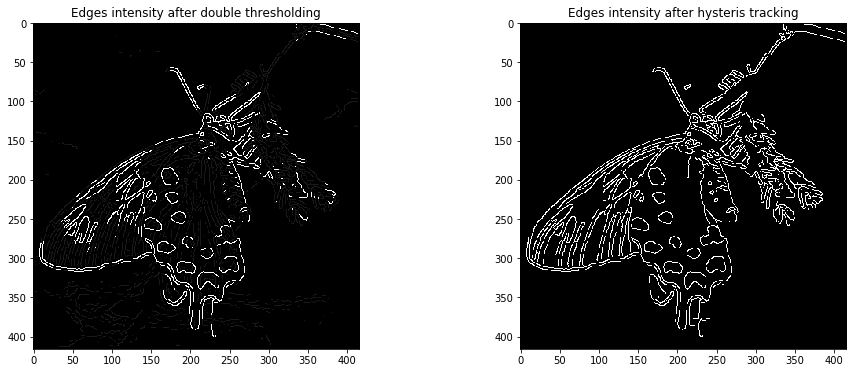

In [85]:
hyster_G = hysteresis_tracking(thresh_G)

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(thresh_G, cmap=cm.gist_gray)
plt.title('Edges intensity after double thresholding')

plt.subplot(122)
plt.imshow(hyster_G, cmap=cm.gist_gray)
plt.title('Edges intensity after hysteris tracking')

plt.tight_layout

## Comparative anaylisis

Here I am going to compare Canny implementation from OpenCV in Python according to two different metrics:
- Speed;
- Accuracy using *RSS*.

They are both equally important, since one of the main reasons why Canny edge detector is still so widely used after all these years, is the speed advantage that it has when compared to much more complex machine learning models (such as, CNNs). This makes it a suitable tool when dealing with real-time applications.

Afterwards, a full pipeline in one take of my custom Canny implementation will be provided, and I'll try to understand which double thresholding approach among the two provided is working the best in this particular case study, by applying it to different images and comparing them with RSS. Bonus section will be provided in the end, where I'll check if my implementation can substain edge detection from a real time capture ([`cv.VideoCapture`](https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture)).

In [86]:
import time

In [87]:
def canny_pipeline(image, size=5, sigma=1.4,
                operator='sobel', method='basic'):
    gray_image = color.rgb2gray(image)

    smooth_kernel = gaussian_kernel(size, sigma)
    smooth_image  = signal.convolve2d(gray_image,
            smooth_kernel, mode='same')
    
    G, theta = gradient_filters(smooth_image,
                        operator=operator)
    
    nms_G = non_max_suppression(G, theta)
    
    thresh_G = double_thresholding(nms_G, method=method)
    
    hyster_G = hysteresis_tracking(thresh_G)
    
    return hyster_G

### Comparison in speed and RSS accuracy
Keep in mind this metrics:
- *False negative* - An edge point is present, but it is not detected
- *False positive* - A non-edge point is detected

<br>

Visual comparison provided, as well, with 6 plots.

In [100]:
image = io.imread('./images/butterfly.bmp')

In [101]:
## Legend symbols ##

# cv - Canny from OpenCV

# o - Otsu's method thresholding
# b - Basic double thresholding

# s - Sobel operator
# p - Prewitt operator

## OpenCV Canny implementation ##
start_time = time.time()

edges_map_cv = cv.Canny(image, 67, 200)
print('Edges map with: OpenCV\nSpeed: {}s\n'
              .format(round(time.time() - start_time, 3)))

weak_map_cv   = np.array(edges_map_cv == 0)
strong_map_cv = np.array(edges_map_cv != 0)

## Otsu thresholding + Sobel operator ##
start_time = time.time()

edges_map_os = canny_pipeline(image, method='otsu')

end_time = time.time()

# False pos and false neg % w.r.t. OpenCV
weak_map_os   = np.array(edges_map_os == 0)
strong_map_os = np.array(edges_map_os != 0)

false_pos_os = np.sum(np.logical_not(np.logical_and(
            weak_map_os, weak_map_cv))) / np.sum(weak_map_cv)
false_neg_os = np.sum(np.logical_not(np.logical_and(
            strong_map_os, strong_map_cv))) / np.sum(strong_map_cv)

print('Edges map with: Otsu thresh + Sobel\nSpeed: {}s, False neg %: {}, False pos %: {}\n'
              .format(round(end_time - start_time, 3),
                      round(false_neg_os, 3), round(false_pos_os, 3)))

## Otsu thresholding + Prewitt operator ##
start_time = time.time()

edges_map_op = canny_pipeline(image, method='otsu', operator='prewitt')

end_time = time.time()

# False pos and false neg % w.r.t. OpenCV
weak_map_op   = np.array(edges_map_op == 0)
strong_map_op = np.array(edges_map_op != 0)

false_pos_op = np.sum(np.logical_not(np.logical_and(
            weak_map_op, weak_map_cv))) / np.sum(weak_map_cv)
false_neg_op = np.sum(np.logical_not(np.logical_and(
            strong_map_op, strong_map_cv))) / np.sum(strong_map_cv)

print('Edges map with: Otsu thresh + Prewitt\nSpeed: {}s, False neg %: {}, False pos %: {}\n'
              .format(round(end_time - start_time, 3),
                      round(false_neg_op, 3), round(false_pos_op, 3)))

## Basic thresholding + Sobel operator ##
start_time = time.time()

edges_map_bs = canny_pipeline(image)

end_time = time.time()

# False pos and false neg % w.r.t. OpenCV
weak_map_bs   = np.array(edges_map_bs == 0)
strong_map_bs = np.array(edges_map_bs != 0)

false_pos_bs = np.sum(np.logical_not(np.logical_and(
            weak_map_bs, weak_map_cv))) / np.sum(weak_map_cv)
false_neg_bs = np.sum(np.logical_not(np.logical_and(
            strong_map_bs, strong_map_cv))) / np.sum(strong_map_cv)

print('Edges map with: Basic thresh + Sobel\nSpeed: {}s, False neg %: {}, False pos %: {}\n'
              .format(round(end_time - start_time, 3),
                      round(false_neg_bs, 3), round(false_pos_bs, 3)))

## Basic thresholding + Prewitt operator ##
start_time = time.time()

edges_map_bp = canny_pipeline(image, operator='prewitt')

end_time = time.time()

# False pos and false neg % w.r.t. OpenCV
weak_map_bp   = np.array(edges_map_bp == 0)
strong_map_bp = np.array(edges_map_bp != 0)

false_pos_bp = np.sum(np.logical_not(np.logical_and(
            weak_map_bp, weak_map_cv))) / np.sum(weak_map_cv)
false_neg_bp = np.sum(np.logical_not(np.logical_and(
            strong_map_bp, strong_map_cv))) / np.sum(strong_map_cv)

print('Edges map with: Basic thresh + Prewitt\nSpeed: {}s, False neg %: {}, False pos %: {}\n'
              .format(round(end_time - start_time, 3),
                      round(false_neg_bp, 3), round(false_pos_bp, 3)))


Edges map with: OpenCV
Speed: 0.004s

Edges map with: Otsu thresh + Sobel
Speed: 0.87s, False neg %: 14.228, False pos %: 0.098

Edges map with: Otsu thresh + Prewitt
Speed: 0.772s, False neg %: 14.224, False pos %: 0.099

Edges map with: Basic thresh + Sobel
Speed: 0.81s, False neg %: 14.148, False pos %: 0.106

Edges map with: Basic thresh + Prewitt
Speed: 0.796s, False neg %: 14.155, False pos %: 0.106



Text(0.5, 1.0, 'Edges map with: OpenCV')

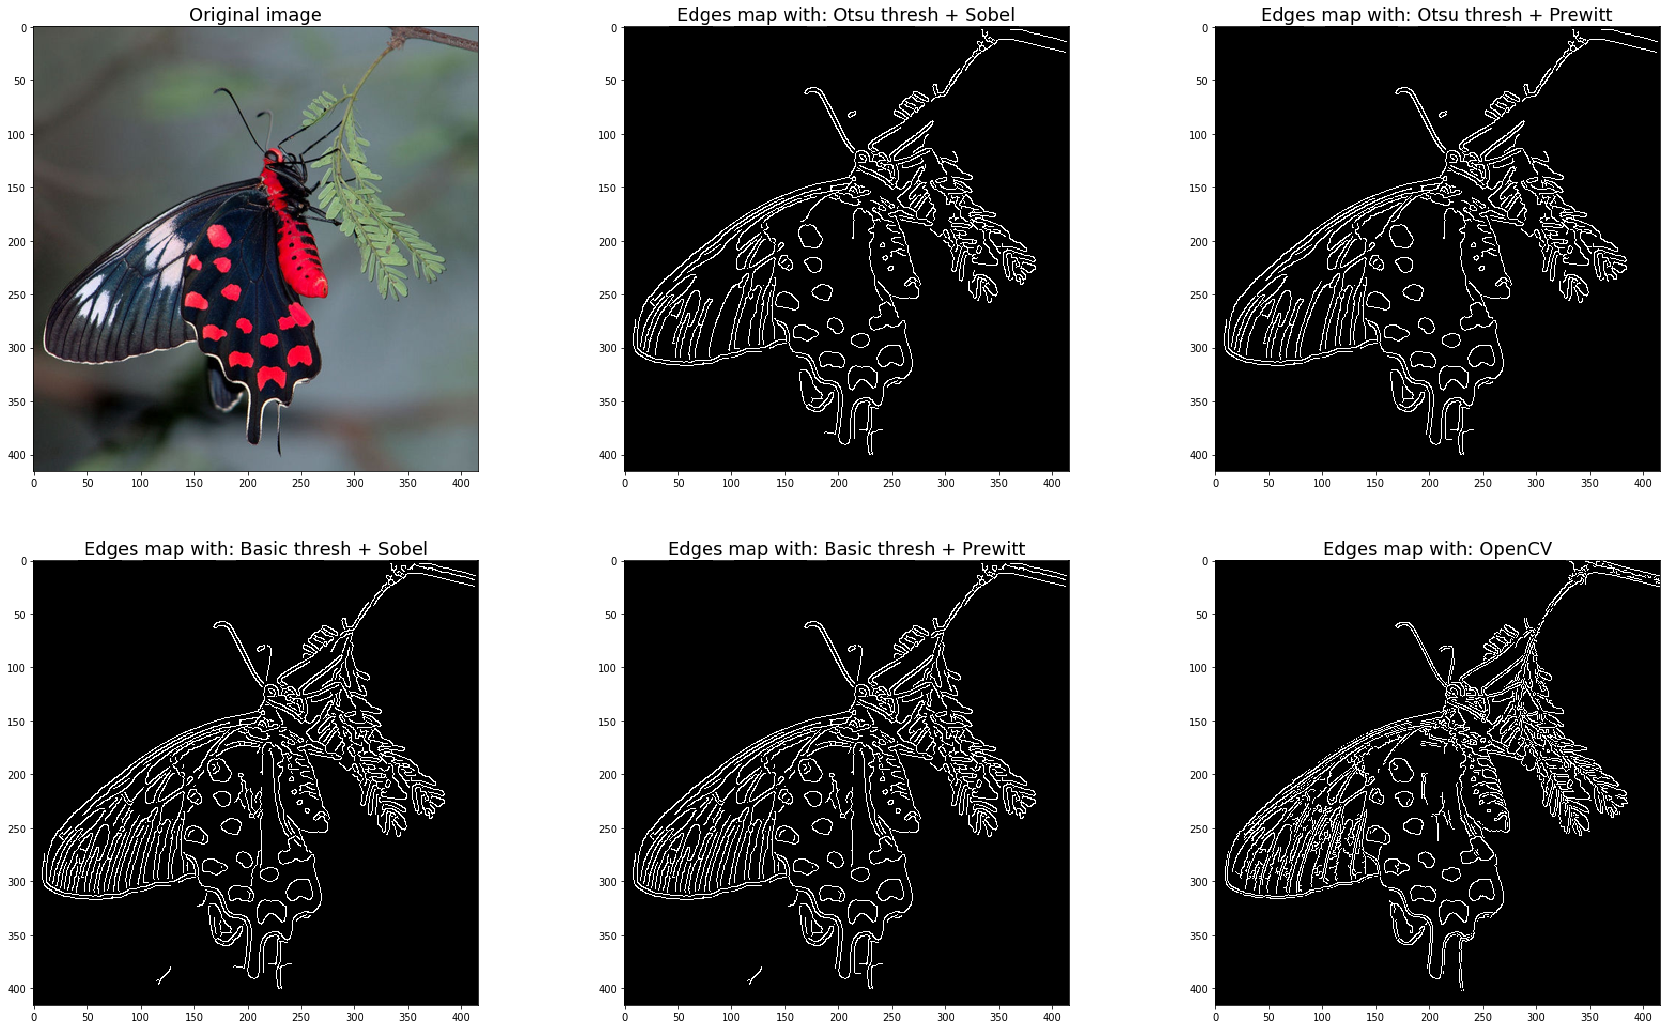

In [102]:
plt.figure(figsize=(30, 18))

plt.subplot(231)
plt.imshow(image)
plt.title('Original image', fontsize=18)

plt.subplot(232)
plt.imshow(edges_map_os, cmap=cm.gist_gray)
plt.title('Edges map with: Otsu thresh + Sobel', fontsize=18)

plt.subplot(233)
plt.imshow(edges_map_op, cmap=cm.gist_gray)
plt.title('Edges map with: Otsu thresh + Prewitt', fontsize=18)

plt.subplot(234)
plt.imshow(edges_map_bs, cmap=cm.gist_gray)
plt.title('Edges map with: Basic thresh + Sobel', fontsize=18)

plt.subplot(235)
plt.imshow(edges_map_bp, cmap=cm.gist_gray)
plt.title('Edges map with: Basic thresh + Prewitt', fontsize=18)

plt.subplot(236)
plt.imshow(edges_map_cv, cmap=cm.gist_gray)
plt.title('Edges map with: OpenCV', fontsize=18)


It is clear from the above images that Sobel operator is the right choice over Prewitt's. Otsu method seems to be the best choice for thresholding when talking about accuracy w.r.t. OpenCV's implementation. False neg/pos % are indeed always in its favour. Speed wise, though, it seems the opposite, since to capture the finest weak edges into strong ones, it would need in average 5-10 Hysteresis iterations.

***Note***: Try with `lena_noisy.bmp` to verify one of Canny edge detector biggest flaws, that is, its inability to deal with impulsive noise. Indeed, even with the right thresholds picks, it produces a notably worse output than with the denoised image `lena.bmp`.

### Bonus section

Capture with OpenCV implementation. Mine was too slow, and often crashed.

In [23]:
# Capture frames from a camera 
video_capt = cv.VideoCapture(0)

# loop runs infinitely after capturing has
# been initialized until the Esc key is pressed
while True:
    # Read frames from a camera 
    ret, frame = video_capt.read()
    
    frame = cv.flip(frame, 1)
    
    # Display the original image 
    cv.imshow('Original capture', frame)

    # Extract edges with from the input image
    # via Canny's ED algorithm and mark
    # them in the output map edges with
    # a 3 to 1 ratio double thresholding
    canny_edges = cv.Canny(frame, 67, 200)

    # Display edges in a frame 
    cv.imshow('Edges map', canny_edges)

    # Wait for Esc key to stop 
    k = cv.waitKey(5) & 0xFF
    if k == 27: 
        break

# Close the window 
video_capt.release() 

# De-allocate any associated memory usage 
cv.destroyAllWindows()
